In [4]:
import polpo.preprocessing.dict as ppdict
import polpo.utils as putils
from matplotlib import pyplot as plt
from polpo.mesh.geometry import (
    DiscreteSurfaces,
    L2SurfacesMetric,
    PullbackMetric,
    SurfacesSpace,
    vertices_to_array,
)
from polpo.mesh.surface import PvSurface
from polpo.preprocessing.load.pregnancy.jacobs import MeshLoader, get_subject_ids
from polpo.preprocessing.mesh.registration import RigidAlignment

In [5]:
SUBJECT_IDS = get_subject_ids(sort=True)
STRUCT = "L_Hipp"

SUBSAMPLE = None

In [6]:
mesh_loader = (
    MeshLoader(
        subject_subset=SUBJECT_IDS,
        struct_subset=[STRUCT],
        derivative="enigma",
        as_mesh=True,
        data_dir="/home/data/maternal/"
    )
    + ppdict.ExtractUniqueKey(nested=True)
    + ppdict.DictMap(ppdict.Subsample(SUBSAMPLE))
)

# subject, session
raw_meshes = mesh_loader()

In [7]:
align_pipe = RigidAlignment(
    target=ppdict.ExtractRandomKey()(putils.get_first(raw_meshes)),
    known_correspondences=True,
)

meshes = (ppdict.DictMap(align_pipe + ppdict.DictMap(PvSurface)))(raw_meshes)

In [8]:
image_space = DiscreteSurfaces(
    (ppdict.ExtractRandomKey() + ppdict.ExtractRandomKey())(meshes).faces,
    equip=False,
).equip_with_metric(L2SurfacesMetric)

space = SurfacesSpace().equip_with_metric(
    PullbackMetric,
    forward_map=vertices_to_array,
    image_space=image_space,
)

meshes_flat = ppdict.UnnestDict(sep="-")(meshes)

dists = putils.pairwise_dists(list(meshes_flat.values()), space.metric)

AttributeError: module 'geomstats.numpy' has no attribute 'asarray'

In [ ]:
from polpo.mesh.varifold.tuning import SigmaFromLengths

sigma_search = SigmaFromLengths(
    ratio_charlen_mesh=2.0,
    ratio_charlen=0.25,
)


ImportError: cannot import name 'Vi' from 'pykeops.numpy' (/home/sak/anaconda3/envs/deformetrica/lib/python3.12/site-packages/pykeops/numpy/__init__.py)

In [9]:
import polpo.preprocessing.dict as ppdict

# one mesh per subject
mesh_per_subject = (
    ppdict.DictMap(ppdict.ExtractRandomKey()) + ppdict.DictToValuesList()
)(meshes)

sigma_search.fit(mesh_per_subject)

metric = sigma_search.optimal_metric_

sigma_search.sigma_

NameError: name 'sigma_search' is not defined

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))

im = ax.imshow(dists, cmap="coolwarm")

plt.colorbar(im)

ax.set_xticks(range(len(meshes_flat)))
ax.set_xticklabels(meshes_flat.keys(), rotation=90)

ax.set_yticks(range(len(meshes_flat)))
ax.set_yticklabels(meshes_flat.keys())

plt.tick_params(axis="both", labelsize=10)

In [53]:
import pyvista as pv
import glob
import os
import numpy as np
import nibabel as nib # Required for reading FreeSurfer geometry

def load_enigma_original_meshes_by_id(root_dir, subset_ids=None):

    meshes = []
    labels = []

    for sub_id in subset_ids:
      # Construct pattern to find this subject's folder. 
      # We add '*' after sub_id to handle session suffixes (e.g. sub-01 matches sub-01_ses-01)
      pattern = os.path.join(root_dir, f"sub-{sub_id}_ses-*", "resliced_mesh_17")
    #   search_pattern = os.path.join(root_dir, f"{sub_id}*", "resliced_mesh_17")
      # print(pattern)
      file_list = sorted(glob.glob(pattern))
      
      if not file_list:
          print(f"  Warning: Could not find mesh for {sub_id}")
          continue
      
      for fpath in file_list:
        coords, faces = nib.freesurfer.io.read_geometry(fpath)

        n_faces = faces.shape[0]
        padding = np.full((n_faces, 1), 3, dtype=np.int64)
        padded_faces = np.hstack((padding, faces)).flatten()
        
        mesh = pv.PolyData(coords, padded_faces)
        meshes.append(mesh)
        
        # Extract label (e.g., 'sub-01_ses-01') from parent folder name
        # path is: .../sub-01_ses-01/resliced_mesh_17
        label_name = os.path.basename(os.path.dirname(fpath))
        labels.append(label_name)
        
    return meshes#, labels


In [54]:
import numpy as np
import torch
import nibabel as nib
import matplotlib.pyplot as plt

def compute_euclidean_matrix(meshes):

    n = len(meshes)
    matrix = np.zeros((n, n))
    
    points_list = [m.points for m in meshes]
    
    for i in range(n):
        for j in range(i, n): 
            diff = points_list[i] - points_list[j]
            dist = np.mean(np.sum(diff**2, axis=1))
            
            matrix[i, j] = dist
            matrix[j, i] = dist
            
    return matrix

def load_enigma_original_meshes(root_dir):
    pattern = os.path.join(root_dir, "sub-*_ses-*", "resliced_mesh_17")
    file_list = sorted(glob.glob(pattern))
    
    if not file_list:
        print(f"No Enigma files found in {root_dir}")
        return []

    print(f"Loading {len(file_list)} Enigma meshes from {root_dir}...")
    
    meshes = []
    labels = [] 
    
    for fpath in file_list:
        coords, faces = nib.freesurfer.io.read_geometry(fpath)

        n_faces = faces.shape[0]
        padding = np.full((n_faces, 1), 3, dtype=np.int64)
        padded_faces = np.hstack((padding, faces)).flatten()
        
        mesh = pv.PolyData(coords, padded_faces)
        meshes.append(mesh)
        
        # Extract label (e.g., 'sub-01_ses-01') from parent folder name
        # path is: .../sub-01_ses-01/resliced_mesh_17
        label_name = os.path.basename(os.path.dirname(fpath))
        labels.append(label_name)
        
    return meshes, labels

def compute_varifold_matrix(meshes, sigma=10.0):
    n = len(meshes)
    matrix = np.zeros((n, n))
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def varifold_kernel(x, y, nx, ny, sigma):
        # Gaussian kernel on positions * Linear kernel on normals (currents/varifold mix)
        # K(x,y) = exp(-|x-y|^2/s^2) * (nx.ny)^2
        
        # Pairwise squared distances
        x_sq = torch.sum(x**2, dim=1, keepdim=True)
        y_sq = torch.sum(y**2, dim=1, keepdim=True)
        dist_sq = x_sq - 2 * torch.matmul(x, y.t()) + y_sq.t()
        
        k_geo = torch.exp(-dist_sq / (sigma**2))
        k_nrm = torch.matmul(nx, ny.t()) ** 2 # Power of 2 makes it unoriented (Varifold)
        
        return k_geo * k_nrm

    descriptors = []
    for m in meshes:
        m_tri = m.triangulate()
        m_tri = m_tri.compute_normals(cell_normals=True, point_normals=False)
        m_tri = m_tri.compute_cell_sizes()
        
        centers = torch.tensor(m_tri.cell_centers().points, dtype=torch.float32, device=device)
        normals = torch.tensor(m_tri.cell_data['Normals'], dtype=torch.float32, device=device)
        areas = torch.tensor(m_tri.cell_data['Area'], dtype=torch.float32, device=device)
        
        # Weighted normals (normal * area)
        weighted_n = normals * areas.unsqueeze(1)
        descriptors.append((centers, weighted_n))

    # --- 2. Compute Inner Products <M_i, M_j> ---
    # We need <A, A> + <B, B> - 2<A, B>
    
    # Precompute self-terms diagonal
    self_terms = np.zeros(n)
    for i in range(n):
        c, wn = descriptors[i]
        self_terms[i] = torch.sum(varifold_kernel(c, c, wn, wn, sigma)).item()

    # Compute cross terms
    for i in range(n):
        for j in range(i + 1, n):
            ci, wni = descriptors[i]
            cj, wnj = descriptors[j]
            
            cross = torch.sum(varifold_kernel(ci, cj, wni, wnj, sigma)).item()
            
            # Dist^2 formula
            val = self_terms[i] + self_terms[j] - 2 * cross
            
            # Numerical stability clip
            val = max(0, val)
            
            matrix[i, j] = val
            matrix[j, i] = val
            
    return matrix

def load_meshes_from_dir(directory, glob_pattern="*.vtk"):
    files = sorted(glob.glob(os.path.join(directory, "**", glob_pattern), recursive=True))
    if not files:
        print(f"no files found in {directory} with pattern {glob_pattern}")
        return []
        
    print(f"Loaded {len(files)} meshes from {directory}")
    return [pv.read(f) for f in files]

def plot_figure(data_cols):
    """
    data_cols: Dictionary {'Title': mesh_list, ...}
    """

    mesh_lists = list(data_cols.values())
    titles = list(data_cols.keys())
    col_data = list(data_cols.values()) 
    n_cols = len(titles)
    
    # fig, axes = plt.subplots(2, n_cols, figsize=(5 * n_cols, 8), constrained_layout=True)
    fig, axes = plt.subplots(2, n_cols, figsize=(6 * n_cols, 8), constrained_layout=True)

    if n_cols == 1: axes = axes.reshape(2, 1)

    for i, (col_title, meshes) in enumerate(zip(titles, mesh_lists)):
    # for i, (col_title, (meshes, labels)) in enumerate(zip(titles, col_data)):
        if not meshes: continue

        # Row 1: Euclidean
        mat_e = compute_euclidean_matrix(meshes)
        ax1 = axes[0, i]
        im1 = ax1.imshow(mat_e, cmap="bwr")
        ax1.set_title(col_title, fontsize=10, pad=10)
        
        fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
        
        # Row 2: Varifold
        mat_v = compute_varifold_matrix(meshes, sigma=5.0) # Adjust sigma based on brain scale
        ax2 = axes[1, i]
        im2 = ax2.imshow(mat_v, cmap='bwr')
        
        fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
        
        # n_subs = len(labels)
        # for ax in [ax1, ax2]:
        #     ax.set_xticks(range(n_subs))
        #     ax.set_yticks(range(n_subs))
            
        #     ax.set_xticklabels(labels, rotation=90, fontsize=8)
        #     ax.set_yticklabels(labels, fontsize=8)


    # Row Labels
    axes[0, 0].set_ylabel("Euclidean dist matrix\n(MSE)", fontsize=12)
    axes[1, 0].set_ylabel("Varifold dist matrix", fontsize=12)

    plt.savefig("distance_matrix_figure.png", dpi=150)
    plt.show()



In [55]:

dir_enigma = "/home/data/maternal/maternal_brain_project/derivatives/enigma_shape"  
dir_enigma_pilot = "/home/data/maternal/maternal_brain_project_pilot/derivatives/enigma_shape_hires_long"  
dir_lddmm  = "/home/sak/polpo/notebooks/how_to/results/regression_example_lddmm/meshes"
dir_eucl   = "/home/sak/polpo/notebooks/how_to/results/regression_example_euclidean"


meshes_enigma_pilot = load_enigma_original_meshes_by_id(dir_enigma_pilot, subset_ids=["01"])
meshes_enigma = load_enigma_original_meshes_by_id(dir_enigma, subset_ids=["1001B", "1004B"])
meshes_lddmm  = load_meshes_from_dir(dir_lddmm)
meshes_eucl   = load_meshes_from_dir(dir_eucl)



Loaded 61 meshes from /home/sak/polpo/notebooks/how_to/results/regression_example_lddmm/meshes
Loaded 63 meshes from /home/sak/polpo/notebooks/how_to/results/regression_example_euclidean


In [56]:
print(meshes_enigma_pilot)

[PolyData (0x7fa15fe62c20)
  N Cells:    5000
  N Points:   2502
  N Strips:   0
  X Bounds:   1.388e+02, 1.640e+02
  Y Bounds:   1.309e+02, 1.542e+02
  Z Bounds:   1.105e+02, 1.496e+02
  N Arrays:   0, PolyData (0x7fa03471b940)
  N Cells:    5000
  N Points:   2502
  N Strips:   0
  X Bounds:   1.389e+02, 1.642e+02
  Y Bounds:   1.309e+02, 1.543e+02
  Z Bounds:   1.105e+02, 1.497e+02
  N Arrays:   0, PolyData (0x7fa0476fc940)
  N Cells:    5000
  N Points:   2502
  N Strips:   0
  X Bounds:   1.387e+02, 1.642e+02
  Y Bounds:   1.308e+02, 1.545e+02
  Z Bounds:   1.104e+02, 1.498e+02
  N Arrays:   0, PolyData (0x7fa047f506a0)
  N Cells:    5000
  N Points:   2502
  N Strips:   0
  X Bounds:   1.390e+02, 1.641e+02
  Y Bounds:   1.307e+02, 1.544e+02
  Z Bounds:   1.108e+02, 1.500e+02
  N Arrays:   0, PolyData (0x7fa03498d420)
  N Cells:    5000
  N Points:   2502
  N Strips:   0
  X Bounds:   1.388e+02, 1.643e+02
  Y Bounds:   1.307e+02, 1.542e+02
  Z Bounds:   1.104e+02, 1.501e+02
  N Ar

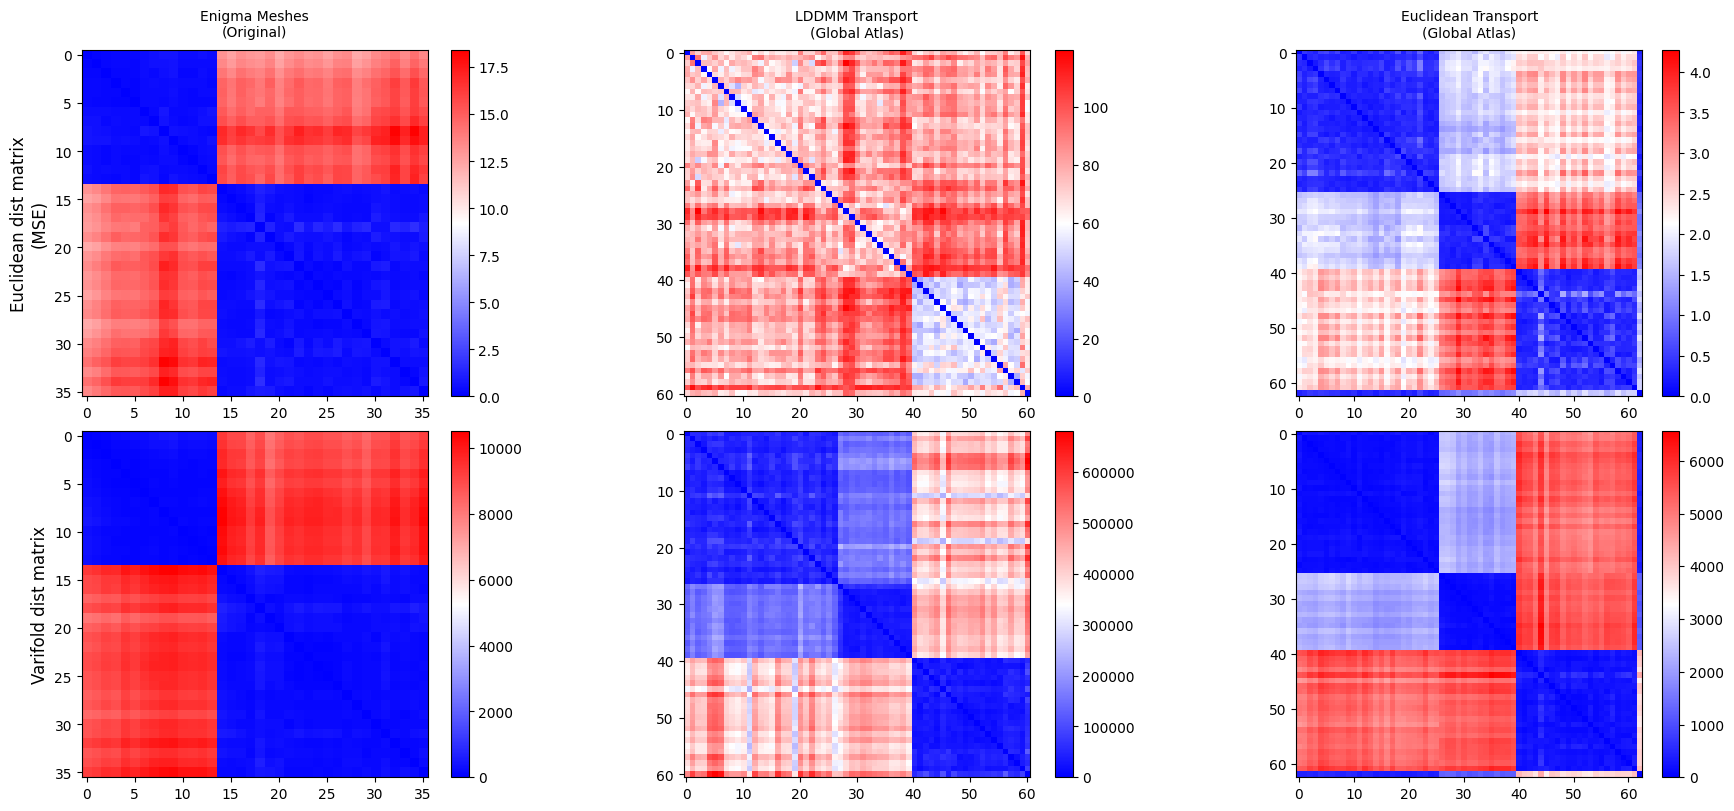

In [57]:

data_to_plot = {
    "Enigma Meshes\n(Original)": meshes_enigma,
    "LDDMM Transport\n(Global Atlas)": meshes_lddmm,
    "Euclidean Transport\n(Global Atlas)": meshes_eucl
}

if any([meshes_enigma, meshes_lddmm, meshes_eucl]):
    plot_figure(data_to_plot)
